# Fine tuning YoloV11 model on football dataset

In [ ]:
!pip install -q ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
# !pip install ultralytics==8.0.196

In [3]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [4]:
from roboflow import Roboflow
from google.colab import userdata
from IPython.display import Image

In [5]:
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Getting all the labels data from roboflow


my_key = userdata.get('robo_API_key')
rf = Roboflow(api_key=my_key)
project = rf.workspace("myproject-24q9u").project("gh_p_league_football_dataset")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


In [ ]:
# plotting the image with labels
plot(
    image_paths='gh_p_league_football_dataset-1/train/images/',
    label_paths='gh_p_league_football_dataset-1/train/labels/',
    num_samples=4,
)

Output hidden; open in https://colab.research.google.com to view.

In [6]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets


my_key = userdata.get('robo_API_key')
rf = Roboflow(api_key=my_key)
project = rf.workspace("myproject-24q9u").project("gh_p_league_football_dataset")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to gh_p_league_football_dataset-1 in yolov11:: 100%|██████████| 210/210 [00:00<00:00, 6820.11it/s]


In [7]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

In [ ]:
# Training the YoloV11 model

%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt  data={dataset.location}/data.yaml batch=6 epochs=50 imgsz=1280 plots=True

/content
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 18.4M/18.4M [00:00<00:00, 244MB/s]
Ultralytics 8.3.44 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/gh_p_league_football_dataset-1/data.yaml, epochs=50, time=None, patience=100, batch=6, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=

In [9]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	train_batch481.jpg
confusion_matrix_normalized.png			    R_curve.png		train_batch482.jpg
confusion_matrix.png				    results.csv		val_batch0_labels.jpg
events.out.tfevents.1733521320.1e1dedf73a24.1973.0  results.png		val_batch0_pred.jpg
F1_curve.png					    train_batch0.jpg	val_batch1_labels.jpg
labels_correlogram.jpg				    train_batch1.jpg	val_batch1_pred.jpg
labels.jpg					    train_batch2.jpg	weights
P_curve.png					    train_batch480.jpg


/content


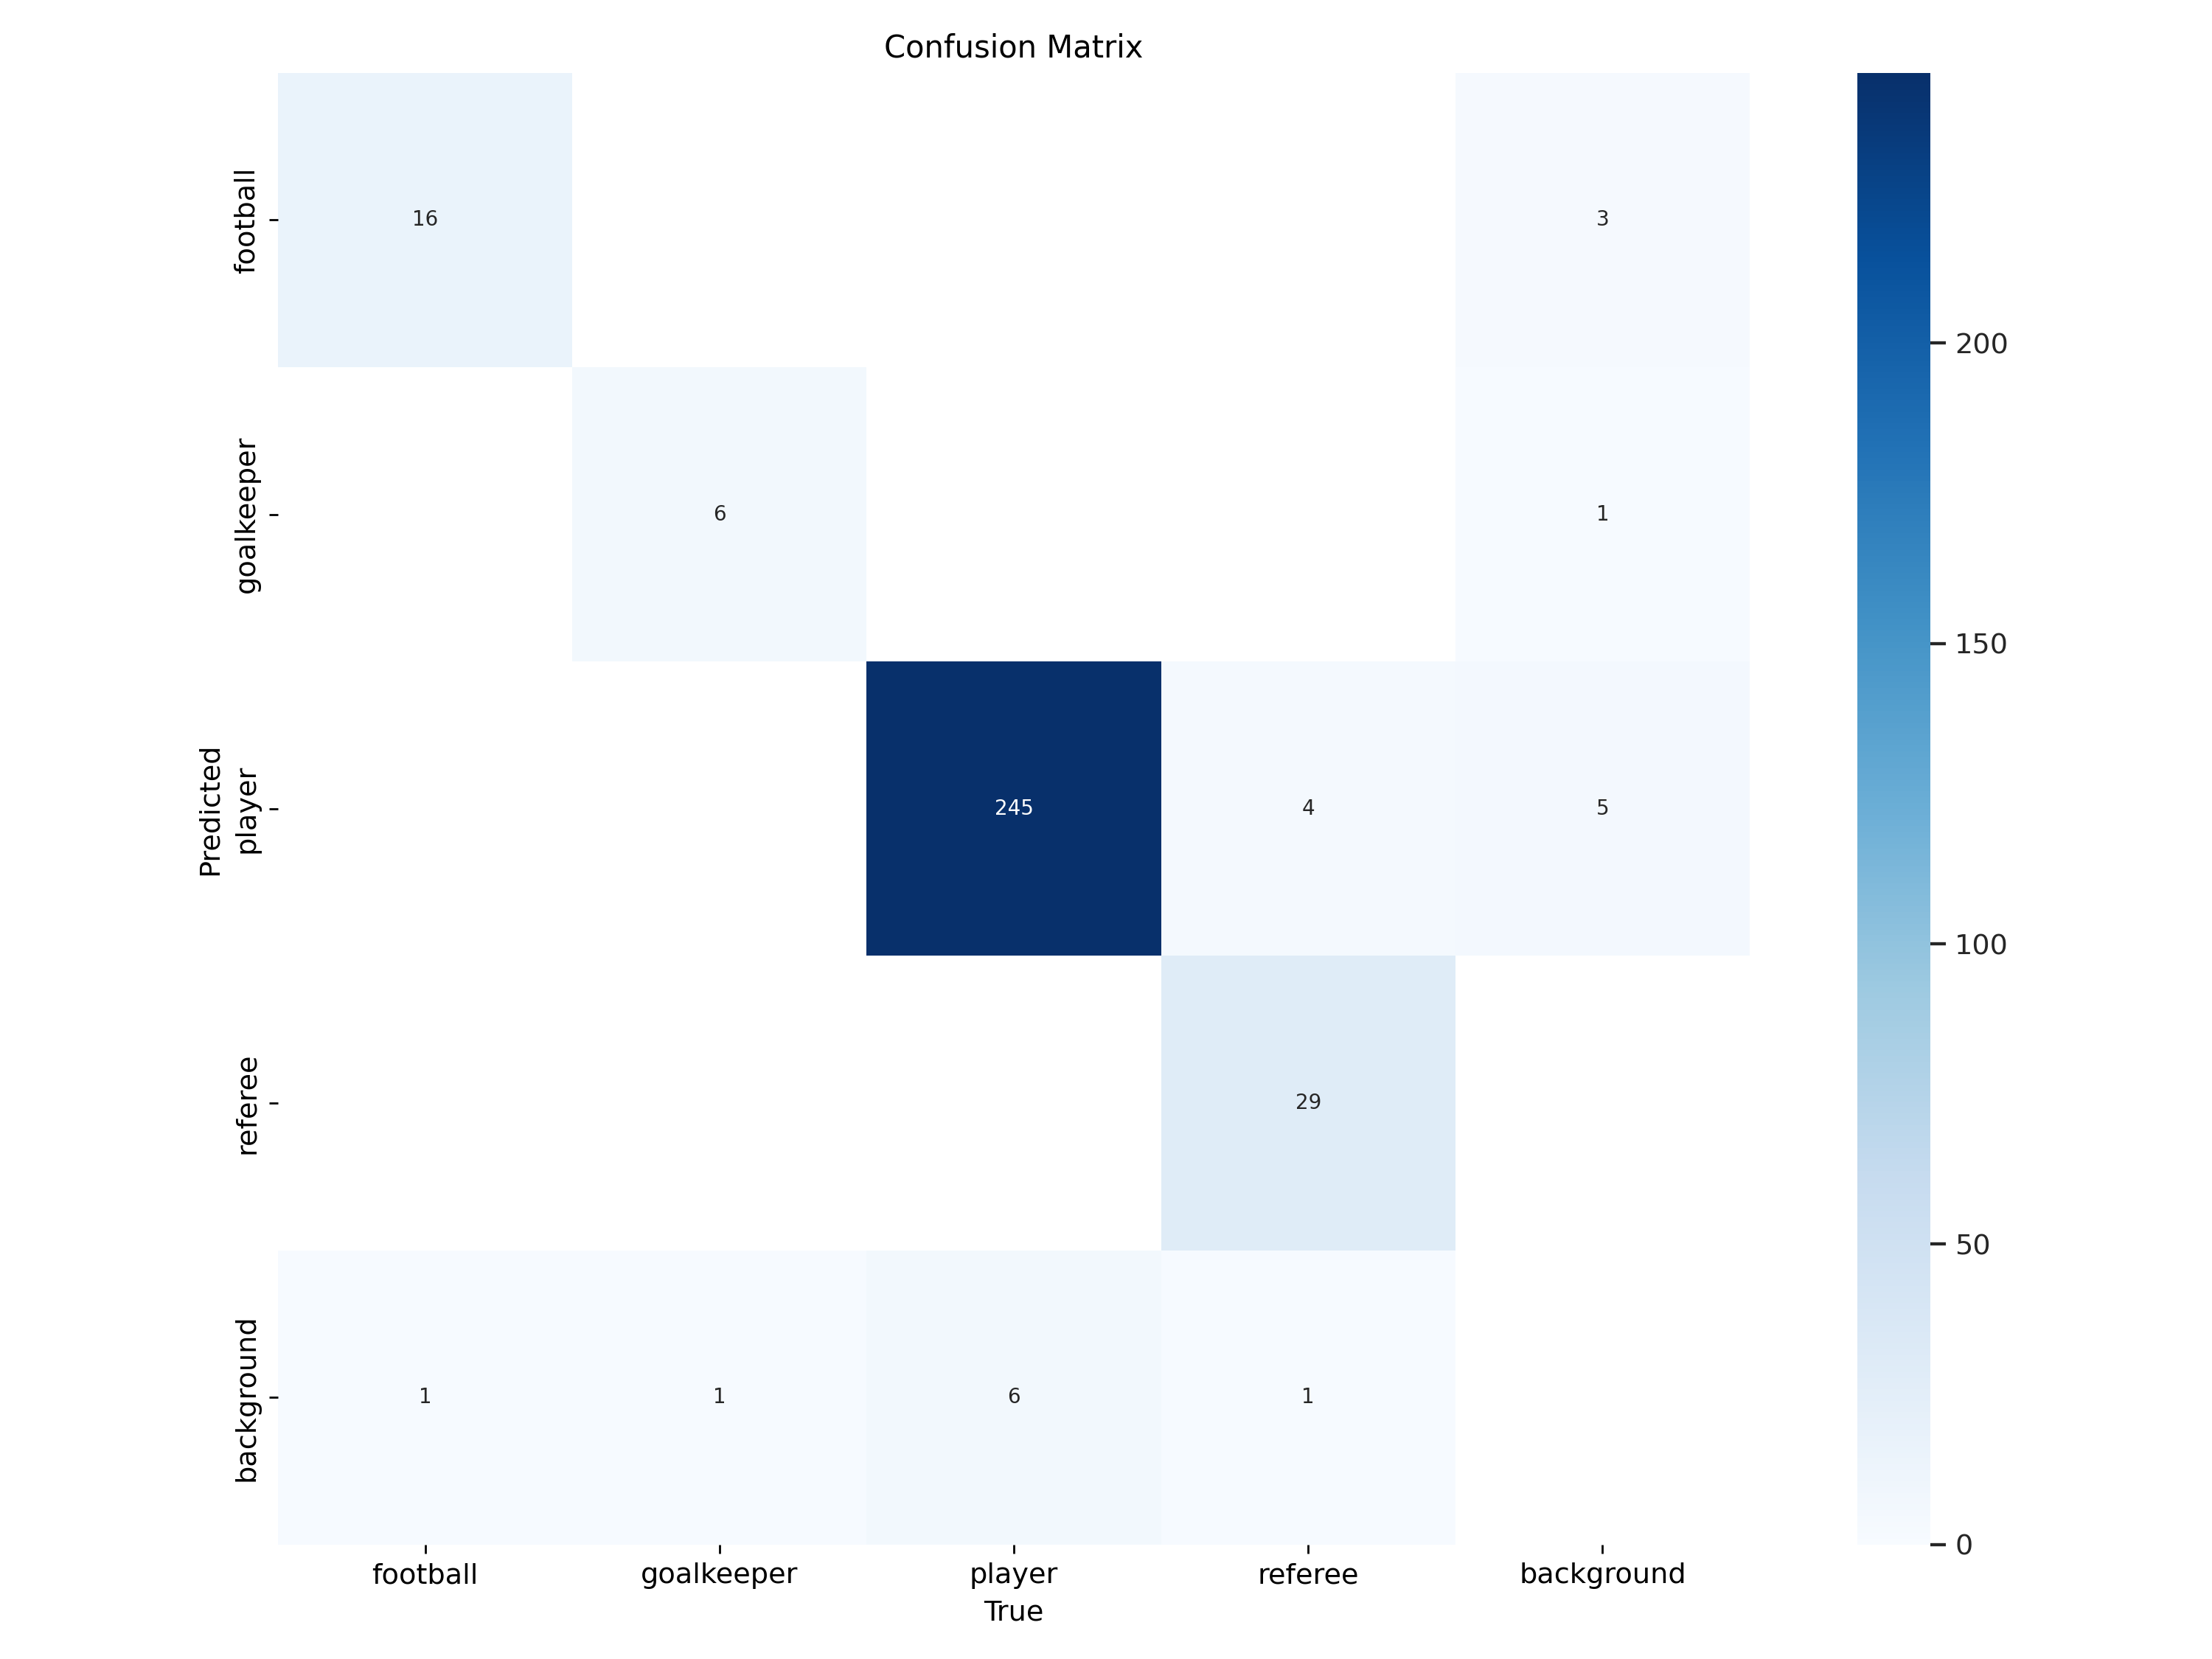

In [10]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


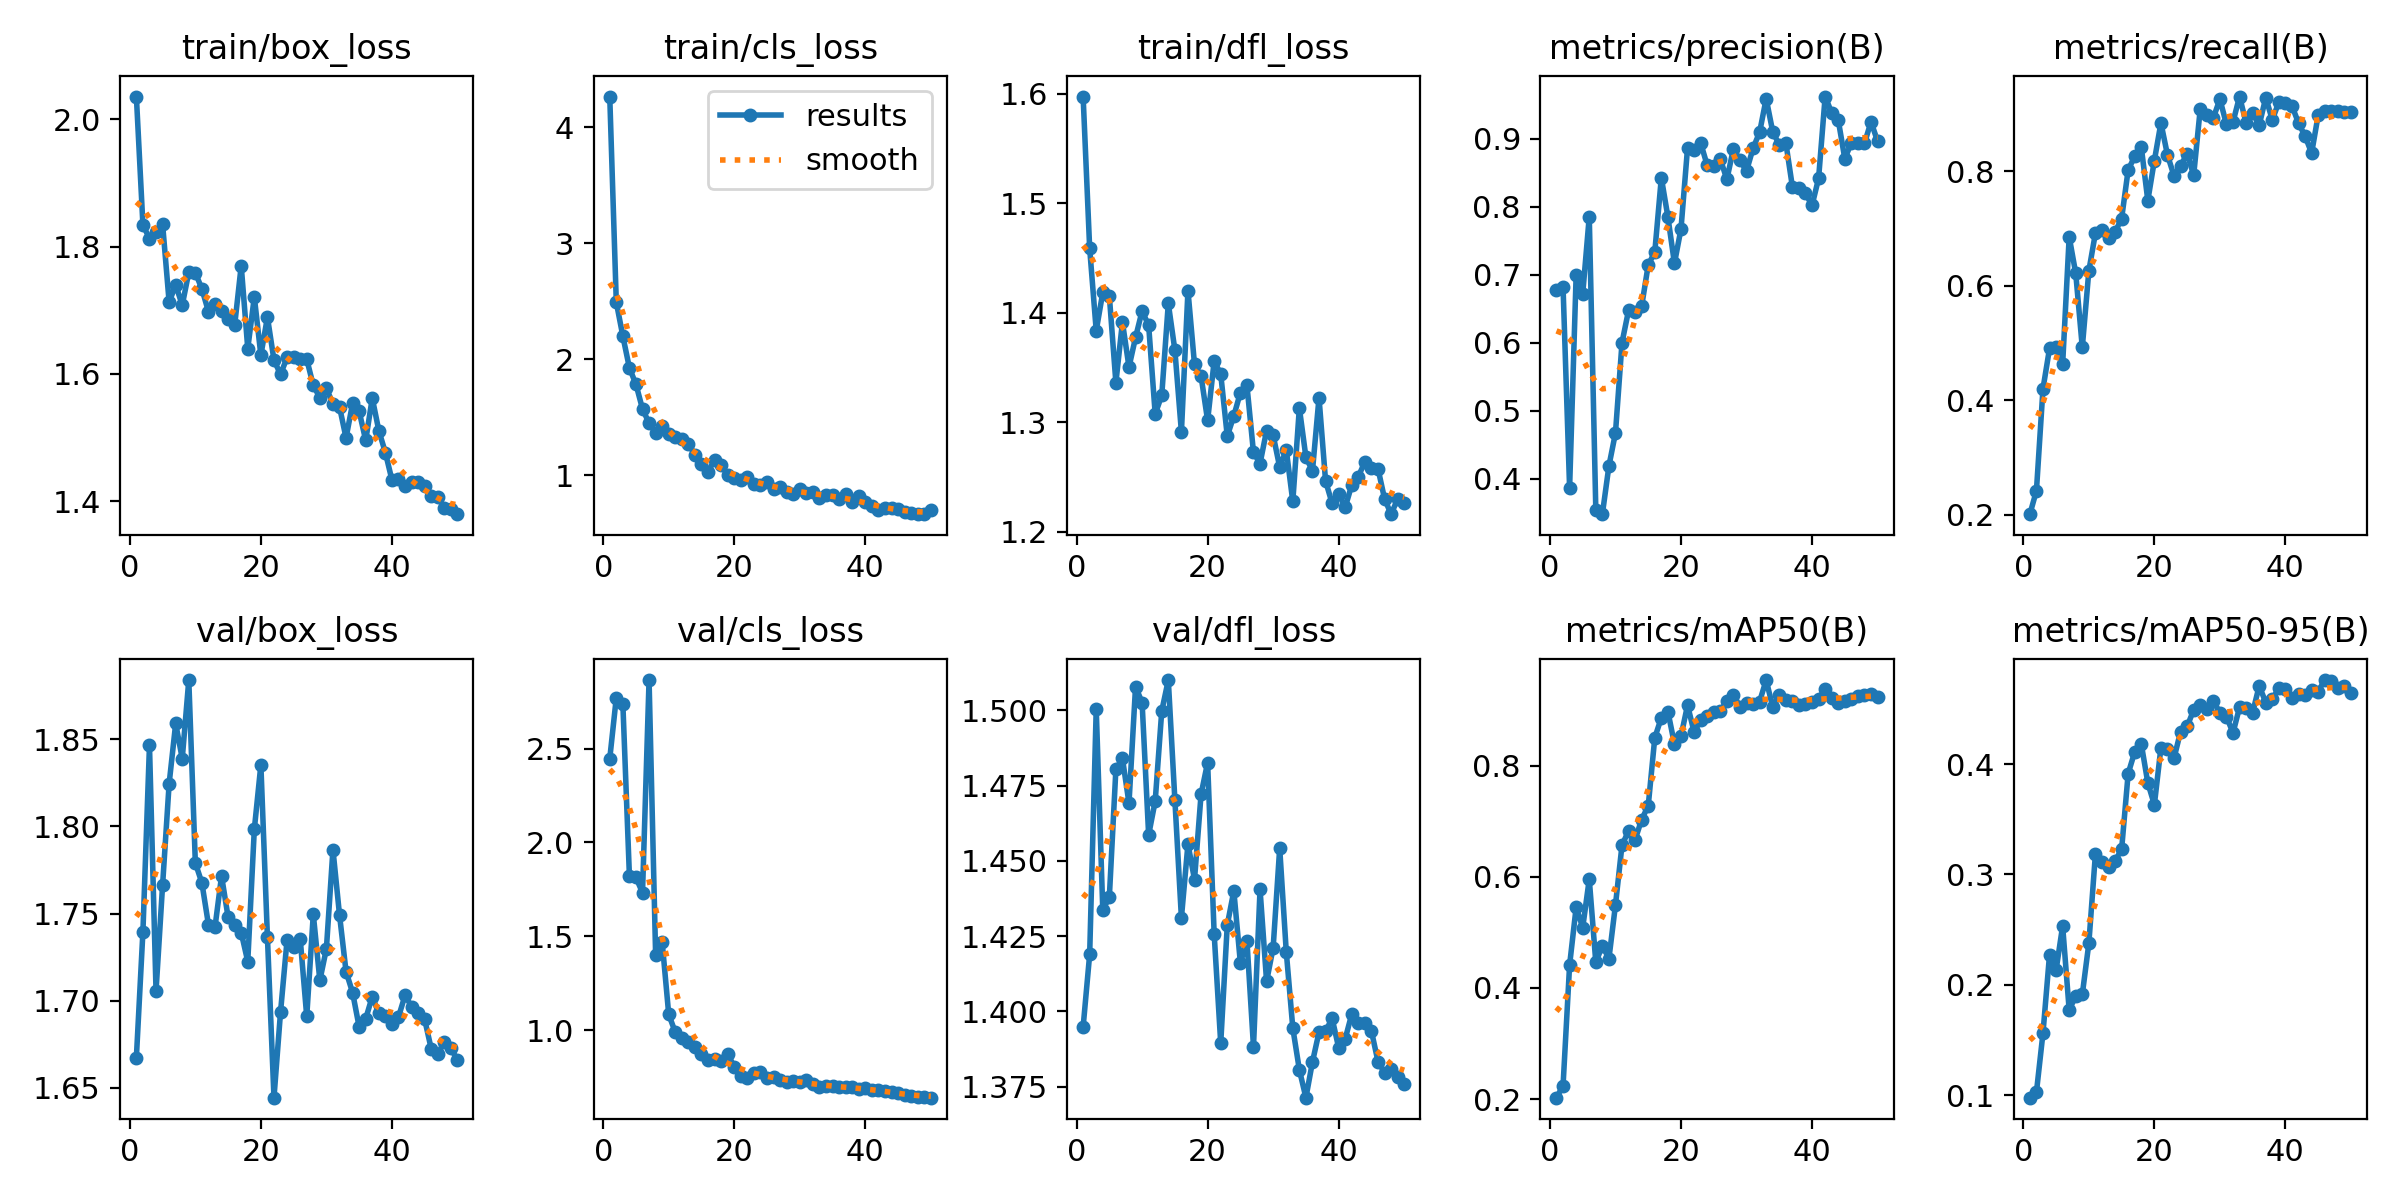

In [11]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


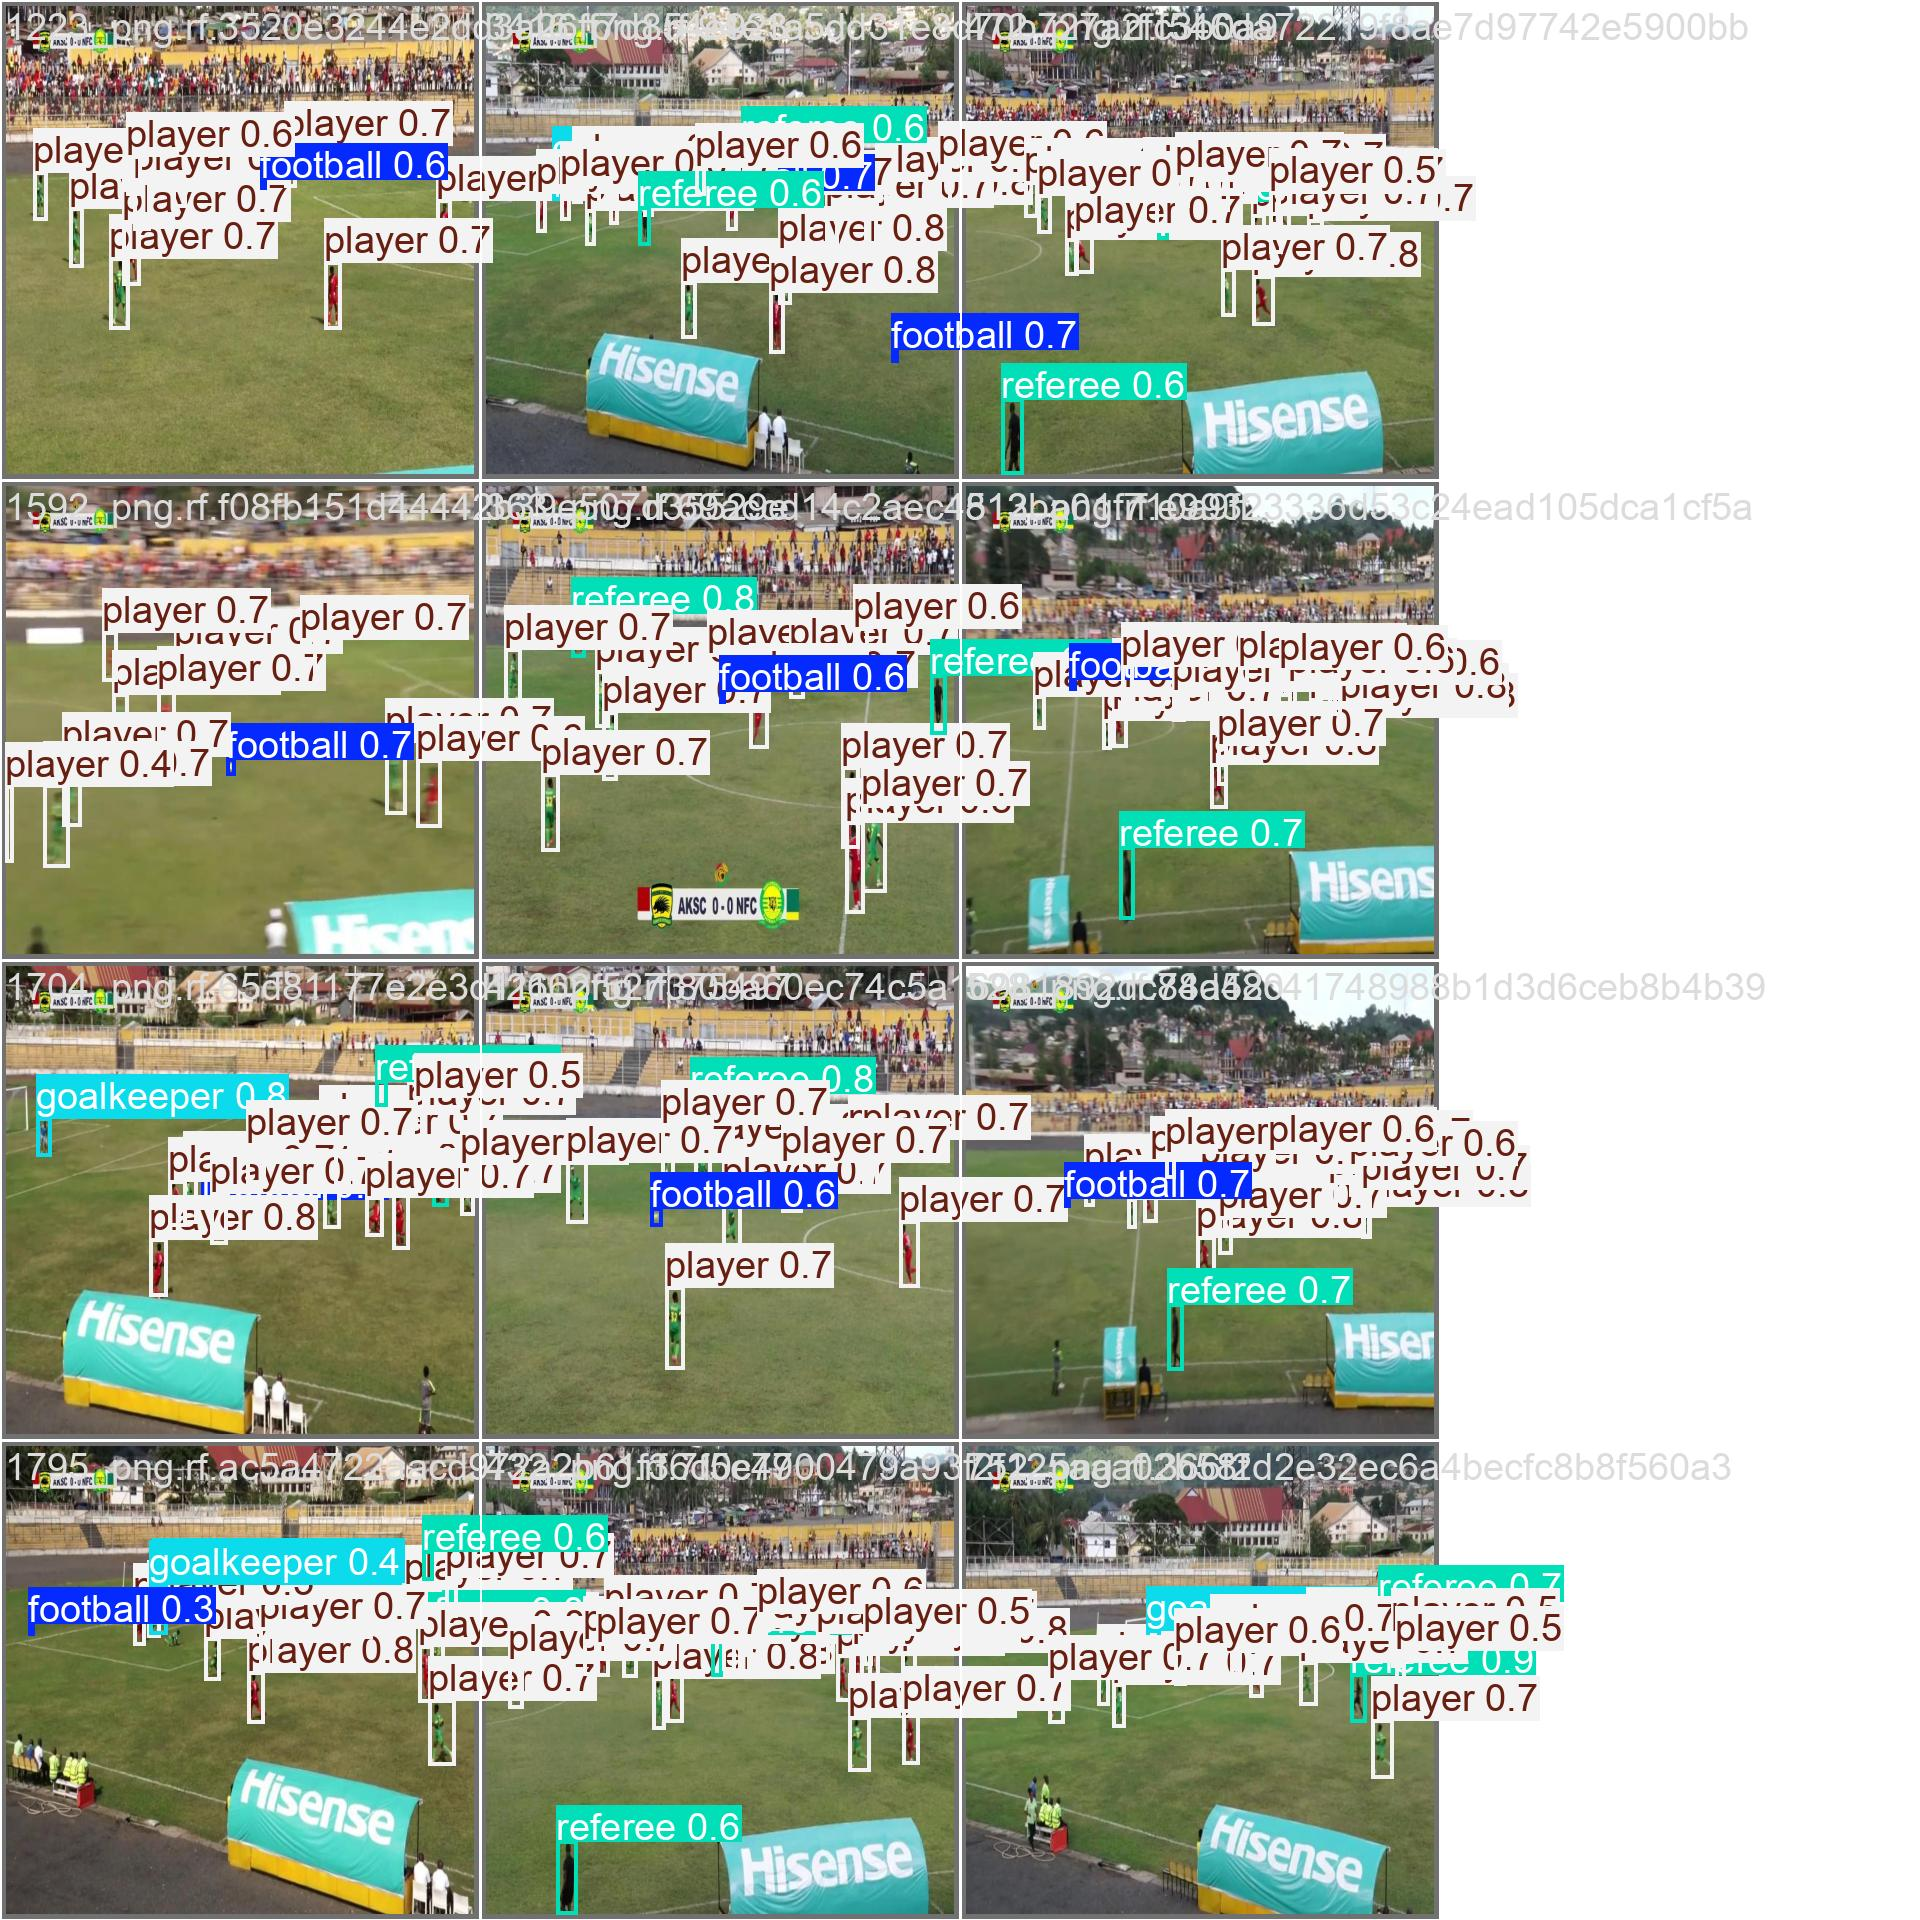

In [13]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [14]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml imgsz=1280

/content
Ultralytics 8.3.44 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/gh_p_league_football_dataset-1/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100% 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:03<00:00,  1.58s/it]
                   all         20        309      0.891      0.891      0.909      0.471
              football         17         17      0.817      0.882      0.775      0.283
            goalkeeper          7          7      0.788      0.857      0.953      0.552
                player         20        251       0.96      0.972      0.975      0.515
               referee         18         34          1      0.851      0.933      0.534
Speed: 33.2ms preprocess, 42.3ms inference, 0.0ms loss, 44.3ms postprocess per image
Results saved to runs

In [ ]:
# Create a zip file for the mode weight

import shutil

shutil.make_archive(f'{HOME}/saveModel', 'zip',f'{HOME}/runs')

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")